## 개요
LSTM을 이용한 신경망 모델은 무엇보다 연결편으로 인한 지연을 예측하는 것에 중점을 뒀다. 그러기 위해서 연결편의 STT와 나머치 feature들을  연결편끼리 sequence로 묶기위해(batch) 노력했다.
그리고 이 모델은 결과값이 Binary Classifier가 아닌 ATT를 예측하는 Regressor이며, 이 예측한 ATT와 계획 STT의 차이가 30분(0.5)보다 크면 지연으로 예측하는 테크닉을 썼다.

## 데이터 로딩과 관련 패키지 로딩
*구글 드라이브와 연동하기 위해 drive.mount를 사용한다.  
*/content/gdrive/ 이후 디렉터리는 사용자에 따라 다르게 설정해주도록 한다.

In [0]:
import pandas as pd
import numpy as np
import re
from google.colab import drive

from sklearn.model_selection import train_test_split
from keras.layers import Input, Dense, LSTM, concatenate, Dropout, LeakyReLU, Embedding
from keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences

drive.mount('/content/gdrive')

#My Drive 이후의 디렉터리는 사용자에 따라 다름에 주의할 것
AFSNT=pd.read_csv('/content/gdrive/My Drive/test_colab/AFSNT.csv',encoding = "ISO-8859-1")
AFSNT.head()

Using TensorFlow backend.


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


,SDT_YY,SDT_MM,SDT_DD,SDT_DY,ARP,ODP,FLO,FLT,REG,AOD,IRR,STT,ATT,DLY,DRR,CNL,CNR
0,2017,1,1,ÀÏ,ARP3,ARP6,J,J1955,SEw3NzE4,D,N,10:05,10:32,N,NaN,N,NaN
1,2017,1,1,ÀÏ,ARP3,ARP6,J,J1954,SEw3NzE4,A,N,9:30,9:31,N,NaN,N,NaN
2,2017,1,1,ÀÏ,ARP3,ARP6,J,J1956,SEw3NzE4,A,N,12:45,13:03,N,NaN,N,NaN
3,2017,1,1,ÀÏ,ARP3,ARP6,J,J1957,SEw3NzE4,D,N,13:25,14:09,Y,C02,N,NaN
4,2017,1,1,ÀÏ,ARP3,ARP6,J,J1958,SEw3NzE4,A,N,16:10,16:31,N,NaN,N,NaN


# 데이터 전처리

### 1.결항 및 소수 공항 제거

In [0]:

#결항 및 소수 공항 제거
drop_list=['C','D','E','G','K']
AFSNT=AFSNT[AFSNT['CNL']=='N']
for i in drop_list:
  AFSNT=AFSNT[AFSNT['FLO']!=i]


### 2.날짜열 통합 및 STT와 ATT 사이의 시간차이 구하기
      1.날짜열 통합
      2. ATT_detail(YYYY-MM-DD-HH-mm)-STT_detaill(YYYY-MM-DD-HH-mm)=INT(지연시간)
       *over_time_idx는 자정을 넘겨 도착한 항공편의 날짜를 하루씩 더하기 위해 주출했다.
     3. 피처로 쓸 칼럼들만 추출한다.

In [0]:
#1.날짜열 통합
AFSNT=AFSNT.rename(columns={'SDT_YY':'Year','SDT_MM':'Month','SDT_DD':'Day'})
AFSNT['DATE']=pd.to_datetime(AFSNT.loc[:, ['Year','Month','Day']])

#날짜를 포한 계획, 실제 시간의 시각 값만 추출
STT_hour=AFSNT['STT'].str.split(':').str.get(0).astype('float64')
ATT_hour=AFSNT['ATT'].str.split(':').str.get(0).astype('float64')
DLY=AFSNT['DLY'].str.get(0)

#하루가 넘어간 열의 인덱스 추출
over_time_idx=AFSNT.loc[(STT_hour>ATT_hour)&(DLY=='Y'),:].index

#2.날짜 포함 열 생성
AFSNT['STT_detail']=pd.to_datetime(AFSNT['DATE'].astype('str')+' '+AFSNT['STT'])
AFSNT['ATT_detail']=pd.to_datetime(AFSNT['DATE'].astype('str')+' '+AFSNT['ATT'])

#하루를 더한다
AFSNT.loc[over_time_idx,'ATT_detail']=AFSNT.loc[over_time_idx,'ATT_detail']+pd.DateOffset(days=1)

#3. 칼럼추출
AFSNT['INT']=AFSNT['ATT_detail']-AFSNT['STT_detail']
AFSNT['INT']=pd.to_timedelta(AFSNT['INT'],unit='m').astype('timedelta64[m]')
AFSNT=AFSNT.loc[:,['DATE','ARP','ODP','FLT','REG','AOD','IRR','Month','STT','ATT','INT','DLY']]
AFSNT.head()

,DATE,ARP,ODP,FLT,REG,AOD,IRR,Month,STT,ATT,INT,DLY
0,2017-01-01,ARP3,ARP6,J1955,SEw3NzE4,D,N,1,10:05,10:32,27.0,N
1,2017-01-01,ARP3,ARP6,J1954,SEw3NzE4,A,N,1,9:30,9:31,1.0,N
2,2017-01-01,ARP3,ARP6,J1956,SEw3NzE4,A,N,1,12:45,13:03,18.0,N
3,2017-01-01,ARP3,ARP6,J1957,SEw3NzE4,D,N,1,13:25,14:09,44.0,Y
4,2017-01-01,ARP3,ARP6,J1958,SEw3NzE4,A,N,1,16:10,16:31,21.0,N


### 3.원핫인코딩

In [0]:
def Dummies(df):
  OneHotDummies=pd.get_dummies(df[['ARP','ODP','AOD','Month']],drop_first=True)#다중공선성을 없애기 위해 첫열은 삭제(ARP1, Arrival, Weekday 0, Month 1)
  
  return OneHotDummies

AFSNT['Month']=AFSNT['Month'].apply(lambda x:str(x))
dummies=Dummies(AFSNT)
dummies.columns=['ARP10','ARP11','ARP12','ARP13','ARP14','ARP15','ARP2','ARP3','ARP4','ARP5','ARP6','ARP7', 'ARP8', 'ARP9','ODP10','ODP11','ODP12','ODP13','ODP14','ODP15','ODP2','ODP3','ODP4','ODP5','ODP6','ODP7', 'ODP8', 'ODP9',
  'DEP','M10','M11','M12','M2','M3','M4','M5','M6','M7','M8','M9']
dummies.head()

,ARP10,ARP11,ARP12,ARP13,ARP14,ARP15,ARP2,ARP3,ARP4,ARP5,ARP6,ARP7,ARP8,ARP9,ODP10,ODP11,ODP12,ODP13,ODP14,ODP15,ODP2,ODP3,ODP4,ODP5,ODP6,ODP7,ODP8,ODP9,DEP,M10,M11,M12,M2,M3,M4,M5,M6,M7,M8,M9
0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
AFSNT=pd.concat([AFSNT,dummies],axis=1)
AFSNT.head()

,DATE,ARP,ODP,FLT,REG,AOD,IRR,Month,STT,ATT,INT,DLY,ARP10,ARP11,ARP12,ARP13,ARP14,ARP15,ARP2,ARP3,ARP4,ARP5,ARP6,ARP7,ARP8,ARP9,ODP10,ODP11,ODP12,ODP13,ODP14,ODP15,ODP2,ODP3,ODP4,ODP5,ODP6,ODP7,ODP8,ODP9,DEP,M10,M11,M12,M2,M3,M4,M5,M6,M7,M8,M9
0,2017-01-01,ARP3,ARP6,J1955,SEw3NzE4,D,N,1,10:05,10:32,27.0,N,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,2017-01-01,ARP3,ARP6,J1954,SEw3NzE4,A,N,1,9:30,9:31,1.0,N,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2017-01-01,ARP3,ARP6,J1956,SEw3NzE4,A,N,1,12:45,13:03,18.0,N,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2017-01-01,ARP3,ARP6,J1957,SEw3NzE4,D,N,1,13:25,14:09,44.0,Y,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,2017-01-01,ARP3,ARP6,J1958,SEw3NzE4,A,N,1,16:10,16:31,21.0,N,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


INT(ATT-STT)의 산포 정도가 매우 크다.  
상위 99%는 91분이지만
최대값이 659분이다.  
이러한 이상치 데이터를 제거해주도록 한다.  
그리고 INT가 음수인 값은 연결편 지연에 영향을 끼치지 않으므로  
0으로 바꿔준다.(제시각 전에 출도착 한것은 제시각으로 바꿔준다.)

In [0]:
AFSNT=AFSNT.loc[AFSNT['IRR']=='N']
AFSNT.drop(['IRR'],inplace=True,axis=1)

print(AFSNT.INT.max())
print(AFSNT.INT.quantile(q=0.99))
print(AFSNT.INT.min())

659.0
91.0
-1325.0


In [0]:
AFSNT['INT']=AFSNT['INT'].apply(lambda x : 91.0 if x>91.0 else x)
AFSNT['INT']=AFSNT['INT'].apply(lambda x : 0.0 if x<0.0 else x)

In [0]:
def getValuebyminute(STT):
  hour,minute=STT.split(':')
  hour=float(hour)
  minute=float(minute)
  return hour*60+minute

AFSNT['STT']=AFSNT['STT'].apply(getValuebyminute)
AFSNT['ATT']=np.sum(AFSNT.loc[:,['STT','INT']],axis=1)
AFSNT['STT']=np.round(AFSNT['STT']/60,4)
AFSNT['ATT']=np.round(AFSNT['ATT']/60,4)

AFSNT['DLY']= AFSNT['DLY'].apply(lambda x: 0 if x=='N' else 1)
AFSNT.head()

,DATE,ARP,ODP,FLT,REG,AOD,Month,STT,ATT,INT,DLY,ARP10,ARP11,ARP12,ARP13,ARP14,ARP15,ARP2,ARP3,ARP4,ARP5,ARP6,ARP7,ARP8,ARP9,ODP10,ODP11,ODP12,ODP13,ODP14,ODP15,ODP2,ODP3,ODP4,ODP5,ODP6,ODP7,ODP8,ODP9,DEP,M10,M11,M12,M2,M3,M4,M5,M6,M7,M8,M9
0,2017-01-01,ARP3,ARP6,J1955,SEw3NzE4,D,1,10.0833,10.5333,27.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,2017-01-01,ARP3,ARP6,J1954,SEw3NzE4,A,1,9.5000,9.5167,1.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2017-01-01,ARP3,ARP6,J1956,SEw3NzE4,A,1,12.7500,13.0500,18.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2017-01-01,ARP3,ARP6,J1957,SEw3NzE4,D,1,13.4167,14.1500,44.0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,2017-01-01,ARP3,ARP6,J1958,SEw3NzE4,A,1,16.1667,16.5167,21.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### 4.정규표현식을 이용해 이상치 제거

A118로 시작하는 편은 ARP3과 ARP12만 운행하지만 ARP8을 운행하는 편이 하나 섞였다.
J15로 시작하는 편은 ARP1과 ARP11을 운행하지만 ARP4를 운행하는 편이 하나 섞였다.
후에 모델링에 차질을 빚지 않기 위해 해당 데이터 들을 삭제한다.

In [0]:
def flight_regex(FLT,string):
  pat=re.compile(string)
  m=pat.match(FLT)
  if m:
    return True
  else:
    return False
  

df1=AFSNT.loc[AFSNT['FLT'].apply(flight_regex,string='A118\d'),:]#
df2=AFSNT.loc[AFSNT['FLT'].apply(flight_regex,string='J15\d\d')]#
idx1=df1.loc[(df1['ARP']=='ARP8') | (df1['ODP']=='ARP8'),:].index.values
idx2=df2.loc[(df2['ARP']=='ARP4') | (df2['ODP']=='ARP4'),:].index.values
print(idx1)
print(idx2)
idx=[]
idx.extend(idx1)
idx.extend(idx2)

[613912 614053]
[84298 84500]


In [0]:
AFSNT.drop(idx,axis=0,inplace=True)

In [0]:
#원핫벡터를 생성한 기존의 칼럼들(ARP,ODP,Month,AOD)는 지운다.
AFSNT.drop(['ARP','ODP','Month','AOD'],axis=1,inplace=True)
AFSNT.head()

,DATE,FLT,REG,STT,ATT,INT,DLY,ARP10,ARP11,ARP12,ARP13,ARP14,ARP15,ARP2,ARP3,ARP4,ARP5,ARP6,ARP7,ARP8,ARP9,ODP10,ODP11,ODP12,ODP13,ODP14,ODP15,ODP2,ODP3,ODP4,ODP5,ODP6,ODP7,ODP8,ODP9,DEP,M10,M11,M12,M2,M3,M4,M5,M6,M7,M8,M9
0,2017-01-01,J1955,SEw3NzE4,10.0833,10.5333,27.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,2017-01-01,J1954,SEw3NzE4,9.5000,9.5167,1.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2017-01-01,J1956,SEw3NzE4,12.7500,13.0500,18.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2017-01-01,J1957,SEw3NzE4,13.4167,14.1500,44.0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,2017-01-01,J1958,SEw3NzE4,16.1667,16.5167,21.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### 5. 전처리 파일 저장

In [0]:
#이때까지 전처리한것들을 저장한다.
AFSNT.to_csv('/content/gdrive/My Drive/test_colab/FLT/AFSNTdummies.csv',index=False)

In [0]:
AFSNT=pd.read_csv('/content/gdrive/My Drive/test_colab/FLT/AFSNTdummies.csv')

AFSNT.head()

,DATE,FLT,REG,STT,ATT,INT,DLY,ARP10,ARP11,ARP12,ARP13,ARP14,ARP15,ARP2,ARP3,ARP4,ARP5,ARP6,ARP7,ARP8,ARP9,ODP10,ODP11,ODP12,ODP13,ODP14,ODP15,ODP2,ODP3,ODP4,ODP5,ODP6,ODP7,ODP8,ODP9,DEP,M10,M11,M12,M2,M3,M4,M5,M6,M7,M8,M9
0,2017-01-01,J1955,SEw3NzE4,10.0833,10.5333,27.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,2017-01-01,J1954,SEw3NzE4,9.5000,9.5167,1.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2017-01-01,J1956,SEw3NzE4,12.7500,13.0500,18.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2017-01-01,J1957,SEw3NzE4,13.4167,14.1500,44.0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,2017-01-01,J1958,SEw3NzE4,16.1667,16.5167,21.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### 6.구간별 파일 저장

EDA를 하면서 항공편면으로 운행하는 구간을 추측할 수 있었다. 예를 들어 A114로 시작하는 항공편은 ARP3과 ARP8만 운행한다. 이러한 규칙성을 토대로 총 58개의 구간과 항공사를 추출하는 정규표현식 list를 만들어, 연결편끼리 추출하기 용이하도록 구간별로 추출하였다.

In [0]:
FLT_list=['A112\d','A114\d','A116\d','A118\d','A119\d',
          'A10\d\d','A12\d\d','A15\d\d','A17\d\d','A19\d\d',
         'B185\d','B189\d','B18[0-4,6-8]\d','B10\d\d','B11\d\d','B12\d\d','B13\d\d',
         'F12\d\d','F13\d\d','F17\d\d','F19\d\d','H11\d\d','H12\d\d','H15\d\d',
         'H16\d\d','H17\d\d','H18\d\d','I13\d\d','I15[0-4,7]\d','I155\d',
          'I1560','I156[1-9]','I158\d','I159\d','J10\d\d','J11\d\d','J12\d\d',
         'J13\d\d','J1413','J1416','J14[0,2-9]\d','J15\d\d','J163\d','J16[0-2,4-9]\d',
         'J182\d','J183\d','J185\d','J18[0-1,4,6-9]\d','J190\d','J192\d','J193\d','J195\d','J196\d',
         'J19[1,4,7-9]\d','L17\d\d','L18\d\d','L193\d','L19[0-2,4-9]\d']

#OneRoute는 한 왕복구간을 운행하는 편들(항공사까지 같음)의 20170101~20190630의 모든 스케줄의 총 집합
for string in FLT_list:
  OneRoute=AFSNT.loc[AFSNT['FLT'].apply(flight_regex,string=string),:]
  OneRoute=OneRoute.sort_values(['DATE','REG','STT'],ascending=True)
  OneRoute.drop('REG', axis=1,inplace=True)
  OneRoute.reset_index(inplace=True,drop=True)
  filepath='/content/gdrive/My Drive/test_colab/FLT/FLTRoute'+string+'.csv'
  OneRoute.to_csv(filepath,index=False)
  print(string," saved")

A112\d  saved
A114\d  saved
A116\d  saved
A118\d  saved
A119\d  saved
A10\d\d  saved
A12\d\d  saved
A15\d\d  saved
A17\d\d  saved
A19\d\d  saved
B185\d  saved
B189\d  saved
B18[0-4,6-8]\d  saved
B10\d\d  saved
B11\d\d  saved
B12\d\d  saved
B13\d\d  saved
F12\d\d  saved
F13\d\d  saved
F17\d\d  saved
F19\d\d  saved
H11\d\d  saved
H12\d\d  saved
H15\d\d  saved
H16\d\d  saved
H17\d\d  saved
H18\d\d  saved
I13\d\d  saved
I15[0-4,7]\d  saved
I155\d  saved
I1560  saved
I156[1-9]  saved
I158\d  saved
I159\d  saved
J10\d\d  saved
J11\d\d  saved
J12\d\d  saved
J13\d\d  saved
J1413  saved
J1416  saved
J14[0,2-9]\d  saved
J15\d\d  saved
J163\d  saved
J16[0-2,4-9]\d  saved
J182\d  saved
J183\d  saved
J185\d  saved
J18[0-1,4,6-9]\d  saved
J190\d  saved
J192\d  saved
J193\d  saved
J195\d  saved
J196\d  saved
J19[1,4,7-9]\d  saved
L17\d\d  saved
L18\d\d  saved
L193\d  saved
L19[0-2,4-9]\d  saved


# 모델링 시작

## 1.Sequence 저장
위의 저장했던 58개 루트는 sequence로 만들기 쉽게 날짜와 시간, 등록기호로 정렬되었다. 이러한 파일들을 순서대로 불러와 시퀀스로 묶어서 배치화 한다.

In [0]:
STTSequence=[] #계획시각의 시퀀스 배열
ATTSequence=[] #실제시각의 시퀀스 배열
FeatureSequence=[] #각 인스턴스의 나머지 피처들의 배열
LabelSequence=[] #각 인스턴스의 레이블의 배열
max_sequence_len=0 #한 연결편당 최대 인스턴스 개수


In [0]:
FLT_list=['A112\d','A114\d','A116\d','A118\d','A119\d',
          'A10\d\d','A12\d\d','A15\d\d','A17\d\d','A19\d\d',
         'B185\d','B189\d','B18[0-4,6-8]\d','B10\d\d','B11\d\d','B12\d\d','B13\d\d',
         'F12\d\d','F13\d\d','F17\d\d','F19\d\d','H11\d\d','H12\d\d','H15\d\d',
         'H16\d\d','H17\d\d','H18\d\d','I13\d\d','I15[0-4,7]\d','I155\d',
          'I1560','I156[1-9]','I158\d','I159\d','J10\d\d','J11\d\d','J12\d\d',
         'J13\d\d','J1413','J1416','J14[0,2-9]\d','J15\d\d','J163\d','J16[0-2,4-9]\d',
         'J182\d','J183\d','J185\d','J18[0-1,4,6-9]\d','J190\d','J192\d','J193\d','J195\d','J196\d',
         'J19[1,4,7-9]\d','L17\d\d','L18\d\d','L193\d','L19[0-2,4-9]\d']

for string in FLT_list:
  #데이터 로딩
  filepath='/content/gdrive/My Drive/test_colab/FLT/FLTRoute'+string+'.csv'
  df=pd.read_csv(filepath)
  
  #데이터 프레임의 연결편의 첫편의 인덱스 추출
  STT_minute_List=df.STT.tolist()
  STT_start_idx=[]
  for i in range(len(STT_minute_List)):  
    if i==0:
      STT_start_idx.append(i)#첫 인덱스
      continue
    if STT_minute_List[i-1]<STT_minute_List[i]:
      continue
    else:
      STT_start_idx.append(i)
  STT_start_idx.append(len(STT_minute_List))#마지막 index+1
  
  #추출한 인덱스로 STT, ATT, DLY, 나머지 피처들을 batch에 붙인 뒤, Sequence에 저장
  for i in range(len(STT_start_idx)-1):
    batch1=[]
    batch2=[]
    batch3=[]
    batch4=[]

    start_idx = STT_start_idx[i]
    end_idx = STT_start_idx[i+1]

    for j in range(start_idx,end_idx):
      instance1=df.loc[j,['STT']].tolist()
      instance2=df.loc[j,['ATT']].tolist()
      instance3=df.loc[j,['DLY']].tolist()
      instance4=df.iloc[j,7:].tolist()
      batch1.append(instance1)
      batch2.append(instance2)
      batch3.append(instance3)
      batch4.append(instance4)
      
    
    STTSequence.append(batch1)
    ATTSequence.append(batch2)
    LabelSequence.append(batch3)
    FeatureSequence.append(batch4)

    if max_sequence_len<len(batch1):
      max_sequence_len=len(batch1)
  print(filepath," sequence padding is completed")    

/content/gdrive/My Drive/test_colab/FLT/FLTRouteA112\d.csv  sequence padding is completed
/content/gdrive/My Drive/test_colab/FLT/FLTRouteA114\d.csv  sequence padding is completed
/content/gdrive/My Drive/test_colab/FLT/FLTRouteA116\d.csv  sequence padding is completed
/content/gdrive/My Drive/test_colab/FLT/FLTRouteA118\d.csv  sequence padding is completed
/content/gdrive/My Drive/test_colab/FLT/FLTRouteA119\d.csv  sequence padding is completed
/content/gdrive/My Drive/test_colab/FLT/FLTRouteA10\d\d.csv  sequence padding is completed
/content/gdrive/My Drive/test_colab/FLT/FLTRouteA12\d\d.csv  sequence padding is completed
/content/gdrive/My Drive/test_colab/FLT/FLTRouteA15\d\d.csv  sequence padding is completed
/content/gdrive/My Drive/test_colab/FLT/FLTRouteA17\d\d.csv  sequence padding is completed
/content/gdrive/My Drive/test_colab/FLT/FLTRouteA19\d\d.csv  sequence padding is completed
/content/gdrive/My Drive/test_colab/FLT/FLTRouteB185\d.csv  sequence padding is completed
/cont

## 2.시퀀스 길이를 맞춰주기 위해 제로 패딩 한다.
시퀀스 길이가 8, 12, 16등으로 달라서 최대 길이 20으로 제로패딩한다.

In [0]:

STTSequence_pad=pad_sequences(sequences=STTSequence,maxlen=20,padding='post',truncating='post',dtype='float32')
FeatureSequence_pad=pad_sequences(sequences=FeatureSequence,maxlen=20,padding='post',truncating='post')
LabelSequence_pad=pad_sequences(sequences=LabelSequence,maxlen=20,padding='post',truncating='post')
ATTSequence_pad=pad_sequences(sequences=ATTSequence,maxlen=20,padding='post',truncating='post',dtype='float32')
print(STTSequence_pad.shape)#(batch_size,sequence_len,input_dim)
print(ATTSequence_pad.shape)#(batch_size,sequence_len,input_dim)
print(LabelSequence_pad.shape)#(batch_size,sequence_len,input_dim)
print(FeatureSequence_pad.shape)#(batch_size,sequence_len,input_dim)

feature_len=FeatureSequence_pad.shape[2]

(136660, 20, 1)
(136660, 20, 1)
(136660, 20, 1)
(136660, 20, 40)
(136660, 20, 1)
136660


In [0]:
np.save('/content/gdrive/My Drive/test_colab/FLT/STTSequence_pad',STTSequence_pad)
np.save('/content/gdrive/My Drive/test_colab/FLT/ATTSequence_pad',ATTSequence_pad)
np.save('/content/gdrive/My Drive/test_colab/FLT/LabelSequence_pad',LabelSequence_pad)
np.save('/content/gdrive/My Drive/test_colab/FLT/FeatureSequence_pad',FeatureSequence_pad)

In [0]:
#각각의 시퀀스들을 로딩
STTSequence_pad=np.load('/content/gdrive/My Drive/test_colab/FLT/STTSequence_pad.npy')
ATTSequence_pad=np.load('/content/gdrive/My Drive/test_colab/FLT/ATTSequence_pad.npy')
LabelSequence_pad=np.load('/content/gdrive/My Drive/test_colab/FLT/LabelSequence_pad.npy')
FeatureSequence_pad=np.load('/content/gdrive/My Drive/test_colab/FLT/FeatureSequence_pad.npy')


## 3.conat_model
카테고리형 변수(feature_sequence)는 dense 층으로,  
STTSequence는 시계열 데이터이므로 LSTM층으로 넣어준 후
concat 메서드를 이용해 병합한다

In [0]:
from sklearn.model_selection import train_test_split
from keras.layers import Input, Dense, LSTM, concatenate, Dropout, LeakyReLU, Embedding
from keras.models import Model
from keras.regularizers import l1,l2
from keras.callbacks import ModelCheckpoint

feature_len=FeatureSequence_pad.shape[2]

#feature_attribute
feature_inputs = Input(shape=(20,feature_len))
feature_x = Dense(24, activation='relu')(feature_inputs)
feature_x = Dense(8, activation='relu')(feature_x)
feature_x = Dropout(0.3)(feature_x)
feature_outputs = Dense(1)(feature_x)
FeatureModel = Model(inputs=feature_inputs, outputs=feature_outputs)

sequence_inputs = Input(shape=(20, 1))
sequence_x=LSTM(20, activation='tanh',return_sequences=True)(sequence_inputs)
sequence_x=LSTM(20, activation='tanh',return_sequences=True)(sequence_x)
sequence_x=LSTM(20, activation='tanh', recurrent_dropout=0.3,return_sequences=True)(sequence_x)
sequence_x=Dense(12,activation='relu')(sequence_x)
sequence_outputs=Dense(1)(sequence_x)
SequenceModel=Model(inputs=sequence_inputs,outputs=sequence_outputs)


concatenated = concatenate([FeatureModel.output, SequenceModel.output])
concatenated = Dense(12, activation='relu', kernel_regularizer=l2(0.005))(concatenated)
concatenated = Dense(4, activation='relu',kernel_regularizer=l1(0.01))(concatenated)
concat_out = Dense(1)(concatenated)

concat_model = Model([feature_inputs, sequence_inputs], concat_out)
concat_model.summary()
concat_model.compile(optimizer='adam', loss='mean_squared_error')

savingpath = '/content/gdrive/My Drive/test_colab/FLT/RNNModel2-{epoch:02d}.hdf5'
checkpoint = ModelCheckpoint(savingpath, monitor= 'val_loss', verbose=1, save_best_only=False, mode='min', period=1)

Model: "model_18"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           (None, 20, 1)        0                                            
__________________________________________________________________________________________________
input_11 (InputLayer)           (None, 20, 40)       0                                            
__________________________________________________________________________________________________
lstm_16 (LSTM)                  (None, 20, 20)       1760        input_12[0][0]                   
__________________________________________________________________________________________________
dense_41 (Dense)                (None, 20, 24)       984         input_11[0][0]                   
___________________________________________________________________________________________

In [0]:
print(STTSequence_pad[10])
print(ATTSequence_pad[10])
print(LabelSequence_pad[10])

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from keras.layers import Input, Dense, LSTM, concatenate, Dropout, LeakyReLU, Embedding
from keras.models import Model, load_model
from keras.regularizers import l1,l2
from keras.callbacks import ModelCheckpoint

STT_train, STT_test, DLY_train, DLY_test, Feature_train, Feature_test, ATT_train, ATT_test = train_test_split(STTSequence_pad, LabelSequence_pad, FeatureSequence_pad, ATTSequence_pad, random_state=10,test_size=0.4)

concat_model.fit([Feature_train,STT_train],ATT_train,epochs=10,batch_size=5,verbose=1,validation_split=0.2,callbacks=[checkpoint])#random+state 10

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 65596 samples, validate on 16400 samples
Epoch 1/10
  340/65596 [..............................] - ETA: 38:57 - loss: 84.4662

# 모델링 결과

## 1.Test data 예측, 구조 출력

In [0]:
from keras.models import load_model
#가장 성능이 잘 나온 2번째 epoch 모델 RNNModel2-02
concat_model = load_model('/content/gdrive/My Drive/test_colab/FLT/RNNModel2-02.hdf5')#random state 10
STT_train, STT_test, DLY_train, DLY_test, Feature_train, Feature_test, ATT_train, ATT_test = train_test_split(STTSequence_pad, LabelSequence_pad, FeatureSequence_pad, ATTSequence_pad, random_state=10,test_size=0.3)

pred_test=concat_model.predict([Feature_test,STT_test])





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


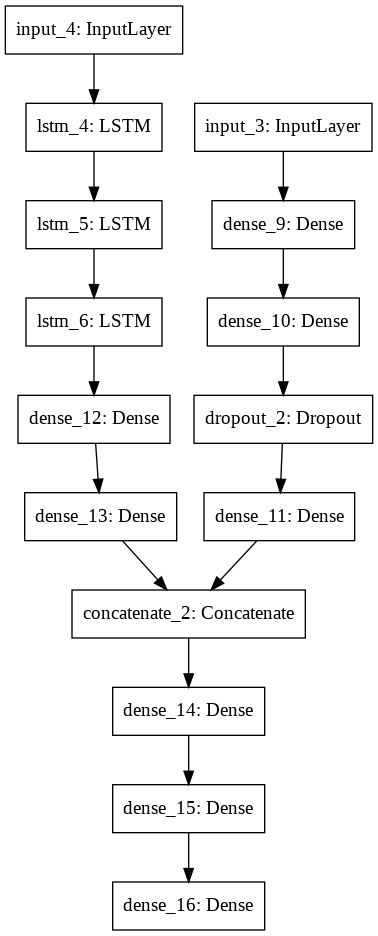

In [0]:
import graphviz
import pydot
from keras.utils.vis_utils import plot_model

plot_model(concat_model,to_file='/content/gdrive/My Drive/test_colab/FLT/FLTModel2-02plot.png')

## 2.Confusion Matrix 추출
제로 패딩된 시퀀스는 예측 레이블(label_YN)이 0이 되지않고  
문자'X'로 대체하여 평가 메트릭에 포함되지 않도록 주의한다.

In [0]:
def label_YN(X,Y,threshold):   
    labels=[]
   
    STT=X[:,:,0].reshape(-1)
    ATT=Y[:,:,0].reshape(-1)
    for i in range(len(STT)):
      if STT[i]!=0:
        Interval_predict=ATT[i]-STT[i]
        if Interval_predict>threshold:
          label=1
        else:
          label=0
        labels.append(label)
      else:
        labels.append("X")
    return labels

def confusion_matrix(Y_test_label,Y_predict_label):
  TP=0
  TN=0
  FN=0
  FP=0
  
  for i in range(len(Y_predict_label)):
    if Y_predict_label[i]=='X':#'for only existing flight'
      continue
    
    if Y_predict_label[i]==0 and Y_test_label[i]==0:
      TN+=1
    elif Y_predict_label[i]==1 and Y_test_label[i]==0:
      FP+=1
    elif Y_predict_label[i]==0 and Y_test_label[i]==1:
      FN+=1
    else:
      TP+=1
  accuracy = np.round((TP + TN) / (TP + TN + FP + FN),4)
  recall = np.round(TP / (TP + FN),4)
  precision= np.round(TP / (TP + FP),4)
  print("confusion matrix :\n")
  print(np.array([[TN,FP],
                [FN,TP]]))
  print("recall : ", recall)
  print("accuracy : ",accuracy)
  print("precision : ", precision)


In [0]:
label_true = DLY_test.reshape(-1)
label_test = label_YN(STT_test,pred_test,threshold=0.5)
confusion_matrix(label_true,label_test)

confusion matrix :

[[189135  60688]
 [ 17030  17274]]
recall :  0.5036
accuracy :  0.7265
precision :  0.2216
